In [37]:
import matplotlib.pyplot as plt
from importlib import reload
import cchdo_tools
import pandas
import numpy as np
from scipy.interpolate import griddata
import itertools
reload(cchdo_tools)

<module 'cchdo_tools' from '/HOME/ras/python/cchdo_toolkit/cchdo_tools.py'>

In [2]:
datapath = '/HOME/ras/datasets/cchdo/subset/'
cruises = cchdo_tools.extract_all_expos(datapath = datapath)

Read 2 expocodes from /HOME/ras/datasets/cchdo/subset/
Expocode 33RR20090320 has 195 files


/HOME/ras/python/cchdo_toolkit/cchdo_tools.py:151: RuntimeWarning: invalid value encountered in greater
  tempvar = expo_ncvars[field][:]


Expocode 318M20091121 has 251 files


RMS adjustment after pass 2: 0.050148


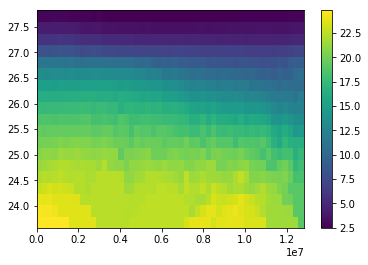

In [38]:
zz, xgrid, ygrid, x, y, z = cchdo_tools.grid_expo_variables(cruises['318M20091121'], 'temperature',yvar='sigma0',nx=50,ny=20,xcorr=1e5,ycorr=0.02)
plt.pcolormesh(xgrid,ygrid,zz)
plt.colorbar()

In [28]:
zz

masked_array(data =
 [[-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- --]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- --]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- --]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- --]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- --]
 [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
  -- --]
 [-- -- -- -- -- -- -- -- -- -- -- --

In [9]:
import metpy.gridding.gridding_functions

In [36]:
y.max()

nan

In [24]:
np.random.rand(10,10).reshape(-1).shape

(100,)

In [26]:
list(zip([1,2,3],[4,5,6]))

[(1, 4), (2, 5), (3, 6)]

In [29]:
import itertools

In [34]:
list(itertools.product([1,2,3],[4,5,6]))

[(1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6)]

In [127]:
def barnes(x,y,z,xi,yi,xcorr,ycorr, npass):
    def calc_weights(xp, yp, x, y):
      dx = np.array([ x1 - x2 for (x1,x2) in itertools.product( xp, x ) ])
      dy = np.array([ y1 - y2 for (y1,y2) in itertools.product( yp, y ) ])
      dx2 = dx*dx
      dy2 = dy*dy
      xcorr2 = xcorr*xcorr
      ycorr2 = ycorr*ycorr
      w = np.exp((-dx2/xcorr2) - (dy2/ycorr2))
      w = w.reshape( (xp.size,-1) )
      w = w/w.sum(axis=-1)[:,np.newaxis]
      return w
    
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    xp = np.array(xi).reshape(-1)
    yp = np.array(yi).reshape(-1)

    # Weight matrix from output points to input points
    wp = calc_weights(xp,yp,x,y)    
    
    # Weight matrix from input points to input poitns
    w = calc_weights(x,y,x,y)    
    
    zpp = zp = np.sum(wp*z,axis=-1)
    zpb = np.zeros(z.shape)
    
    for iter in range(2,npass+1):
#       print(iter, w.shape, wp.shape, zp.shape, zpa.shape, zpb.shape)
      if np.mod(iter,2)==0:
        zpa = zpb + np.sum((z-zpb)*w, axis=-1)
        zp  = zp  + np.sum((z-zpa)*wp,axis=-1)
        zpn = zp
        print(iter, w.shape, wp.shape, z.shape, zp.shape, zpa.shape, zpb.shape)

      else:
        zpb = zpa + np.sum((z-zpa)*w, axis=-1)
        zp  = zp  + np.sum((z-zpb)*wp,axis=-1)
        zpp = zp
      print('RMS adjustment after pass %d: %f' % (iter, np.std(zpn-zpp)))
    
    return zp.reshape(xi.shape)


In [133]:
x = [1,2,3] ; y = [4,5,6] ; z = [10, 20, 30]
xi = np.linspace(1,3,100) ; yi = np.linspace(4,6,100)
xi, yi = np.meshgrid(xi,yi)
xcorr = 1 ; ycorr = 1
z= barnes(x,y,z,xi,yi,xcorr,ycorr,10)

2 (3, 3) (10000, 3) (3,) (10000,) (3,) (3,)
RMS adjustment after pass 2: 0.472027
RMS adjustment after pass 3: 0.056529
4 (3, 3) (10000, 3) (3,) (10000,) (3,) (3,)
RMS adjustment after pass 4: 0.006770
RMS adjustment after pass 5: 0.000811
6 (3, 3) (10000, 3) (3,) (10000,) (3,) (3,)
RMS adjustment after pass 6: 0.000097
RMS adjustment after pass 7: 0.000012
8 (3, 3) (10000, 3) (3,) (10000,) (3,) (3,)
RMS adjustment after pass 8: 0.000001
RMS adjustment after pass 9: 0.000000
10 (3, 3) (10000, 3) (3,) (10000,) (3,) (3,)
RMS adjustment after pass 10: 0.000000


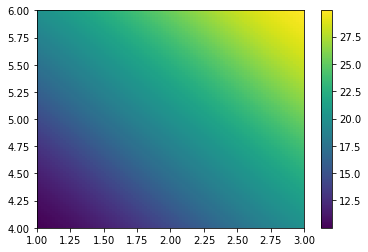

In [136]:
plt.pcolormesh(xi,yi,z); plt.colorbar()

In [71]:
a = b = 5*2

In [76]:
mod(4,3)

NameError: name 'mod' is not defined

In [73]:
b=b+5

In [75]:
a,b

(10, 15)